### About the Dataset:

1. id: unique id for a news article
2. title: the title of a news article
3. author: author of the news article
4. text: the text of the article; could be incomplete
5. label: a label that marks whether the news article is real or fake:
           1: Fake news
           0: Real News

In [1]:
import re

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import itertools

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import PassiveAggressiveClassifier, SGDClassifier, RidgeClassifier, LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, VotingClassifier, StackingClassifier

from sklearn.svm import SVC

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from wordcloud import WordCloud, STOPWORDS

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pepi_\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
news_dataset = pd.read_csv('data/fake-news/train.csv')

In [5]:
news_dataset.head()

id                                              title              author  \
0   0  House Dem Aide: We Didn’t Even See Comey’s Let...       Darrell Lucus   
1   1  FLYNN: Hillary Clinton, Big Woman on Campus - ...     Daniel J. Flynn   
2   2                  Why the Truth Might Get You Fired  Consortiumnews.com   
3   3  15 Civilians Killed In Single US Airstrike Hav...     Jessica Purkiss   
4   4  Iranian woman jailed for fictional unpublished...      Howard Portnoy   

                                                text  label  
0  House Dem Aide: We Didn’t Even See Comey’s Let...      1  
1  Ever get the feeling your life circles the rou...      0  
2  Why the Truth Might Get You Fired October 29, ...      1  
3  Videos 15 Civilians Killed In Single US Airstr...      1  
4  Print \nAn Iranian woman has been sentenced to...      1

# EDA

In [6]:
news_dataset.shape

(20800, 5)

In [7]:
news_dataset.isnull().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
news_dataset.label.value_counts()

1    10413
0    10387
Name: label, dtype: int64

In [9]:
news_dataset = news_dataset.fillna(value = {"title": "", "author": "", "text": ""})

In [10]:
news_dataset.isna().any()

id        False
title     False
author    False
text      False
label     False
dtype: bool

In [11]:
news_dataset['data'] = news_dataset['author']+' '+news_dataset['title']

In [12]:
print(news_dataset['data'])

0        Darrell Lucus House Dem Aide: We Didn’t Even S...
1        Daniel J. Flynn FLYNN: Hillary Clinton, Big Wo...
2        Consortiumnews.com Why the Truth Might Get You...
3        Jessica Purkiss 15 Civilians Killed In Single ...
4        Howard Portnoy Iranian woman jailed for fictio...
                               ...                        
20795    Jerome Hudson Rapper T.I.: Trump a ’Poster Chi...
20796    Benjamin Hoffman N.F.L. Playoffs: Schedule, Ma...
20797    Michael J. de la Merced and Rachel Abrams Macy...
20798    Alex Ansary NATO, Russia To Hold Parallel Exer...
20799              David Swanson What Keeps the F-35 Alive
Name: data, Length: 20800, dtype: object


In [13]:
news_dataset[news_dataset["data"] == ""]

Empty DataFrame
Columns: [id, title, author, text, label, data]
Index: []

In [14]:
X = news_dataset.drop(columns='label', axis=1)
Y = news_dataset['label']

In [15]:
len(news_dataset)

20800

In [16]:
len(news_dataset[news_dataset.label == 1])

10413

In [17]:
len(news_dataset[news_dataset.label == 0])

10387

In [18]:
print(X,'\n\n\n\n',Y)

          id                                              title  \
0          0  House Dem Aide: We Didn’t Even See Comey’s Let...   
1          1  FLYNN: Hillary Clinton, Big Woman on Campus - ...   
2          2                  Why the Truth Might Get You Fired   
3          3  15 Civilians Killed In Single US Airstrike Hav...   
4          4  Iranian woman jailed for fictional unpublished...   
...      ...                                                ...   
20795  20795  Rapper T.I.: Trump a ’Poster Child For White S...   
20796  20796  N.F.L. Playoffs: Schedule, Matchups and Odds -...   
20797  20797  Macy’s Is Said to Receive Takeover Approach by...   
20798  20798  NATO, Russia To Hold Parallel Exercises In Bal...   
20799  20799                          What Keeps the F-35 Alive   

                                          author  \
0                                  Darrell Lucus   
1                                Daniel J. Flynn   
2                             Consortiu

# Stemming

In [19]:
stem_words = PorterStemmer()

In [20]:
def stemming(data):
    
    stemmed_content = re.sub('[^a-zA-Z]',' ',data)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [stem_words.stem(word) for word in stemmed_content if not word in stopwords.words("english")]
    stemmed_content = ' '.join(stemmed_content)
    
    return stemmed_content

In [21]:
news_dataset['data'] = news_dataset['data'].apply(stemming)

# Visualizing

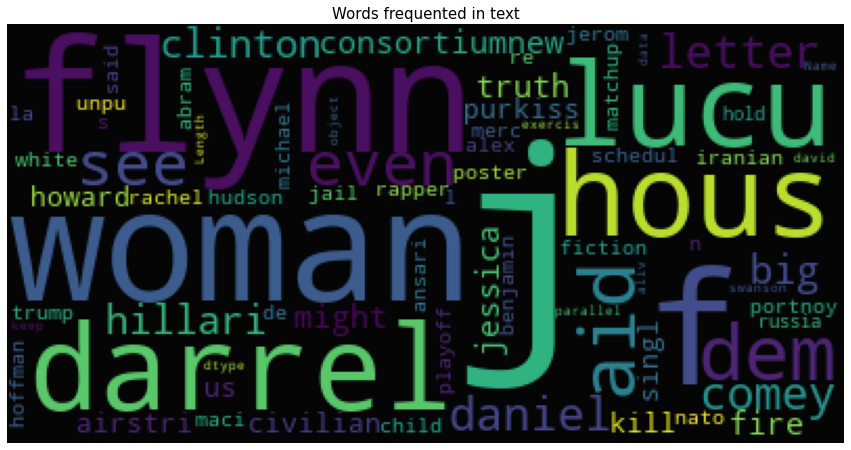

In [22]:
wordcloud = WordCloud(
                        background_color='black',
                        stopwords=STOPWORDS,
                        max_words=200, 
                        random_state=42).generate(str(news_dataset['data']))

plt.figure(figsize=(15,10))
plt.axis("off")
plt.title("Words frequented in text", fontsize=15)
plt.imshow(wordcloud.recolor(colormap= 'viridis' , random_state=42), alpha=0.98)
plt.show()

In [23]:
print(news_dataset['data'])

0        darrel lucu hous dem aid even see comey letter...
1        daniel j flynn flynn hillari clinton big woman...
2                   consortiumnew com truth might get fire
3        jessica purkiss civilian kill singl us airstri...
4        howard portnoy iranian woman jail fiction unpu...
                               ...                        
20795    jerom hudson rapper trump poster child white s...
20796    benjamin hoffman n f l playoff schedul matchup...
20797    michael j de la merc rachel abram maci said re...
20798    alex ansari nato russia hold parallel exercis ...
20799                            david swanson keep f aliv
Name: data, Length: 20800, dtype: object


# Modelling

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    # Here we print the if confusion matrix is normalized
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # Here we include text that shows confusion matrix values
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [25]:
def model_report(model, X_test, y_test):
    pred = model.predict(X_test)

    print(accuracy_score(y_test, pred) * 100)
    print(classification_report(y_test, pred))

    cm = confusion_matrix(y_test, pred)

    plot_confusion_matrix(cm, classes=['Fake News', 'Real News'])

In [26]:
X = news_dataset['data'].values
Y = news_dataset['label'].values

In [27]:
print(X,'\n\n\n\n',Y)

['darrel lucu hous dem aid even see comey letter jason chaffetz tweet'
 'daniel j flynn flynn hillari clinton big woman campu breitbart'
 'consortiumnew com truth might get fire' ...
 'michael j de la merc rachel abram maci said receiv takeov approach hudson bay new york time'
 'alex ansari nato russia hold parallel exercis balkan'
 'david swanson keep f aliv'] 



 [1 0 1 ... 0 1 1]


In [28]:
vectorizer = TfidfVectorizer()

vectorizer.fit(X)

X = vectorizer.transform(X)

In [29]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.1, stratify=Y, random_state=42)

In [30]:
model = LogisticRegression()
model.fit(X_train, Y_train)

LogisticRegression()

# Accuracy Check

### Training Accuracy 

In [31]:
X_train_prediction = model.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [32]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  0.9877136752136753


### Testing Accuracy 

In [33]:
X_test_prediction = model.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

In [34]:
print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9759615384615384


# Model Prediction

In [35]:
X_new = X_test[1]
X_new_2 = X_test[0]

X_New_3 = X_test[22]

result = model.predict(X_new)
result_1 = model.predict(X_new_2)


def get_type(prediction):
    if (prediction[0]==0):
        return 'Real'
    else:
        return 'Fake'
    
print(f"The news is {get_type(result)}")
print(f"The news is {get_type(result_1)}")

The news is Fake
The news is Fake


97.59615384615384
              precision    recall  f1-score   support

           0       0.99      0.96      0.98      1039
           1       0.96      0.99      0.98      1041

    accuracy                           0.98      2080
   macro avg       0.98      0.98      0.98      2080
weighted avg       0.98      0.98      0.98      2080

Confusion matrix, without normalization


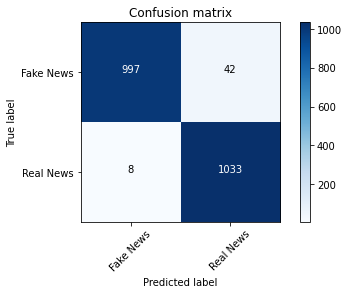

In [36]:
model_report(model, X_test, Y_test)

In [37]:
print(Y_test[0])

1


In [38]:
model2 = DecisionTreeClassifier(random_state = 42)
model2.fit(X_train, Y_train)

DecisionTreeClassifier(random_state=42)

In [39]:
X_test_prediction = model2.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, Y_test)

print('Accuracy score of the test data : ', test_data_accuracy)

Accuracy score of the test data :  0.9899038461538462


In [40]:
X_train_prediction = model2.predict(X_train)
training_data_accuracy = accuracy_score(X_train_prediction, Y_train)

In [41]:
print('Accuracy score of the training data : ', training_data_accuracy)

Accuracy score of the training data :  1.0


In [42]:
model2.score(X_test, Y_test)

0.9899038461538462

In [43]:
pa = PassiveAggressiveClassifier(n_iter_no_change= 50, loss = "squared_hinge")
pa.fit(X_train, Y_train)

PassiveAggressiveClassifier(loss='squared_hinge', n_iter_no_change=50)

99.13461538461539
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1039
           1       0.99      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080

Confusion matrix, without normalization


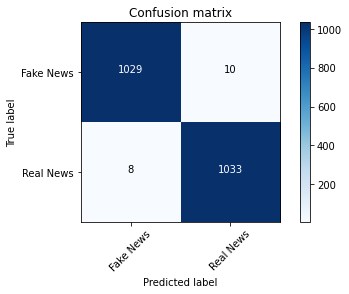

In [44]:
model_report(pa, X_test, Y_test)

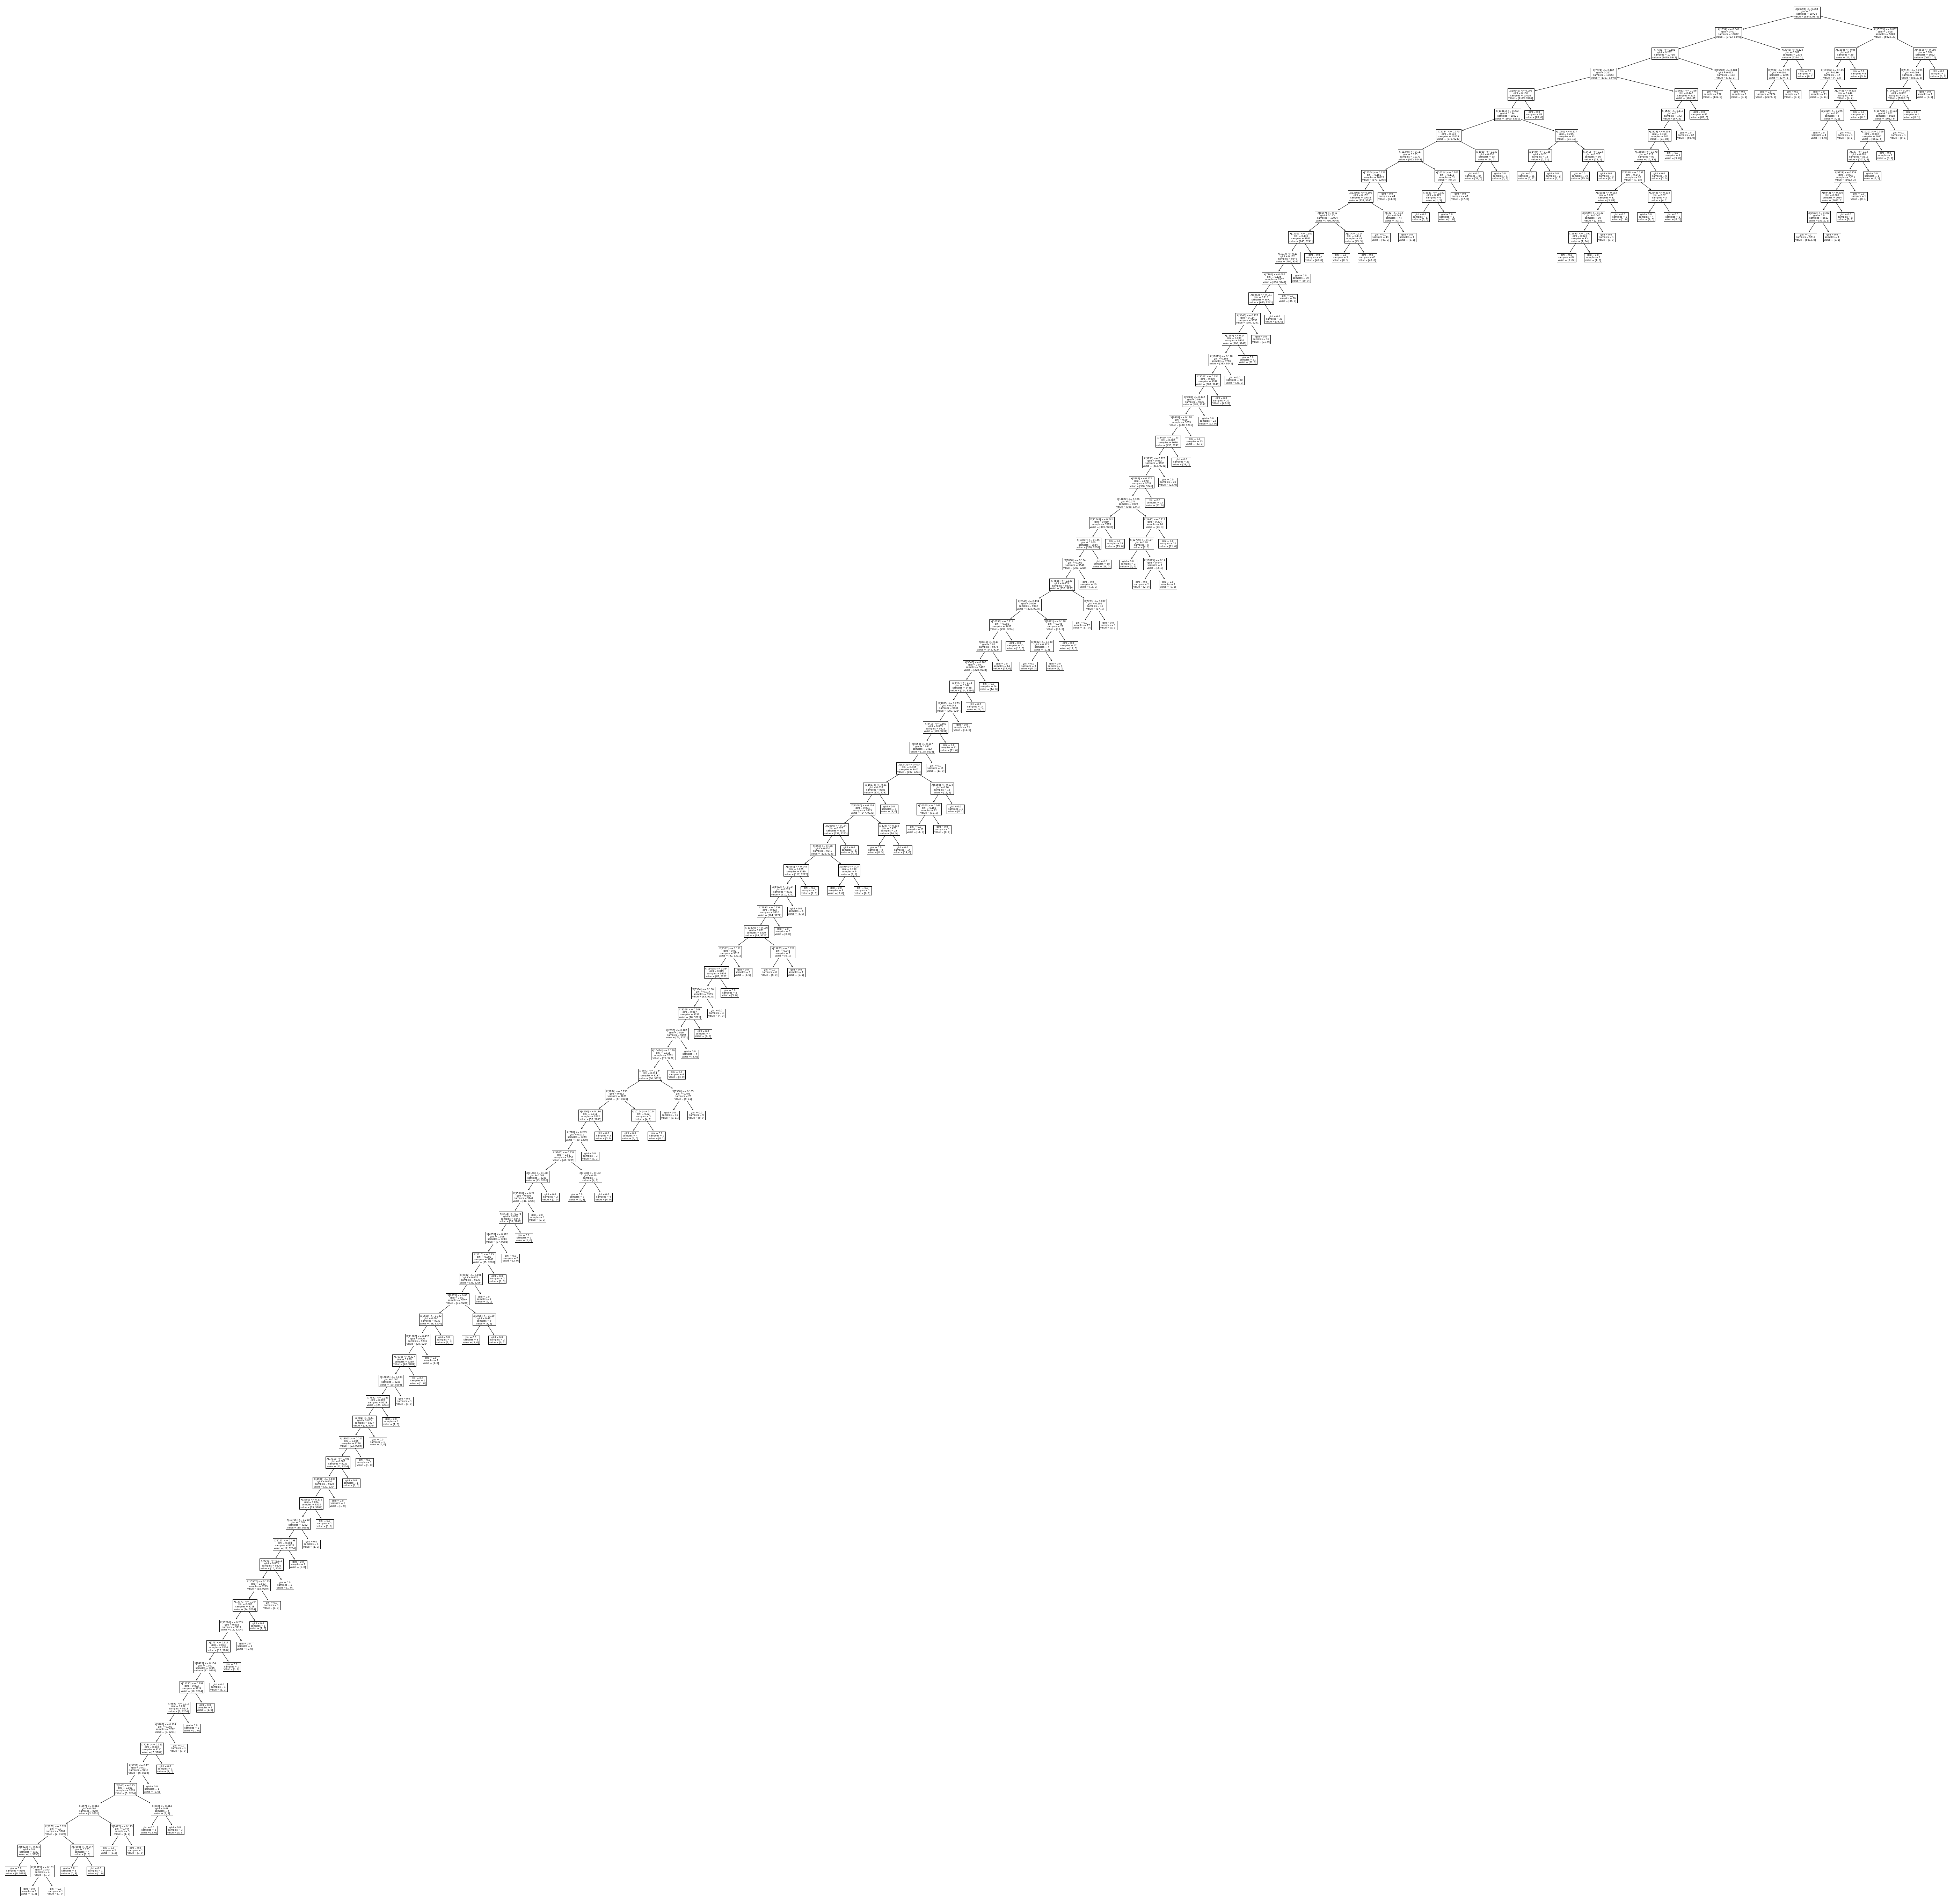

In [45]:
fig = plt.figure(figsize=(100, 100))

ax = fig.gca()

plot_tree(model2, ax=ax)

plt.show()

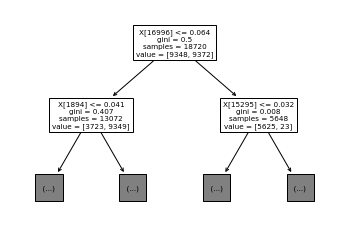

In [46]:
plot_tree(model2, max_depth=1)

plt.show()

In [47]:
parameters_PassiveAggressive = {'C': (0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.),
                                'fit_intercept': (True, False),
                                'n_iter_no_change': (1, 2, 3, 5, 8, 13, 21, 50),
                                'shuffle': (True, False),
                                'loss': ('hinge', 'squared_hinge'),
                                'warm_start': (True, False)}


In [48]:
pa_params = GridSearchCV(PassiveAggressiveClassifier(), parameters_PassiveAggressive, n_jobs=-1, verbose=1)
pa_params.fit(X_train, Y_train)

Fitting 5 folds for each of 1024 candidates, totalling 5120 fits


GridSearchCV(estimator=PassiveAggressiveClassifier(), n_jobs=-1,
             param_grid={'C': (0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0),
                         'fit_intercept': (True, False),
                         'loss': ('hinge', 'squared_hinge'),
                         'n_iter_no_change': (1, 2, 3, 5, 8, 13, 21, 50),
                         'shuffle': (True, False),
                         'warm_start': (True, False)},
             verbose=1)

In [49]:
pa_best = pa_params.best_estimator_

pa_best.fit(X_train, Y_train)

PassiveAggressiveClassifier(C=2.0, loss='squared_hinge', n_iter_no_change=3,
                            warm_start=True)

99.1826923076923
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1039
           1       0.99      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080

Confusion matrix, without normalization


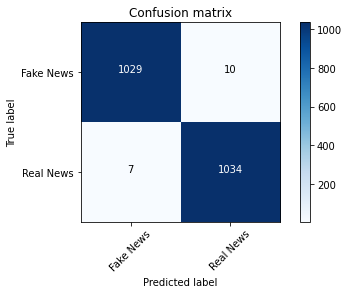

In [50]:
model_report(pa_best, X_test, Y_test)

In [51]:
additional_data = pd.read_csv("data/fake_or_real_news.csv")


additional_data = additional_data.rename(columns = {"Unnamed: 0": "id"})

additional_data.label = additional_data.label.replace(["REAL", "FAKE"], [0, 1])


labels = additional_data.label

additional_data = additional_data.drop(columns=["label"])

additional_data["title"] = additional_data["title"].apply(stemming)

In [52]:
tfidf_v = TfidfVectorizer(max_features = 100000, ngram_range=(1,3))

X_additional = tfidf_v.fit_transform(additional_data["title"])

In [53]:
X_additional_train, X_additional_test, y_additional_train, y_additional_test = train_test_split(X_additional, labels, random_state=0, test_size = 0.1, stratify = labels)

50.1577287066246
              precision    recall  f1-score   support

           0       0.67      0.01      0.01       317
           1       0.50      1.00      0.67       317

    accuracy                           0.50       634
   macro avg       0.58      0.50      0.34       634
weighted avg       0.58      0.50      0.34       634

Confusion matrix, without normalization


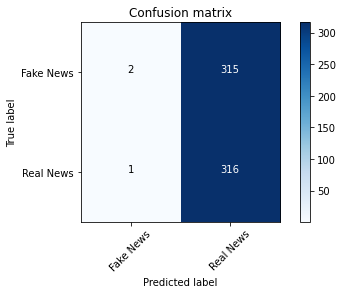

In [54]:
model_report(pa, X_additional_test[:, :17128], y_additional_test[:17128])

In [55]:
tree_params = {'criterion': ['gini', 'entropy'], 'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15,
                                                               20, 30, 40, 50, 70, 90, 120, 150], 'splitter': ['best', 'random'], 'random_state': [42, 256]}

grid_search = GridSearchCV(DecisionTreeClassifier(), tree_params, cv = 5)

grid_search.fit(X_train, Y_train)


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,
                                       40, 50, 70, 90, 120, 150],
                         'random_state': [42, 256],
                         'splitter': ['best', 'random']})

In [56]:
best_tree_params = grid_search.best_params_

In [57]:
best_tree_params

{'criterion': 'gini', 'max_depth': 70, 'random_state': 256, 'splitter': 'best'}

In [58]:
tree = DecisionTreeClassifier(max_depth=70, random_state=256,splitter='best')

tree.fit(X_train, Y_train)

DecisionTreeClassifier(max_depth=70, random_state=256)

99.08653846153847
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1039
           1       0.99      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080

Confusion matrix, without normalization


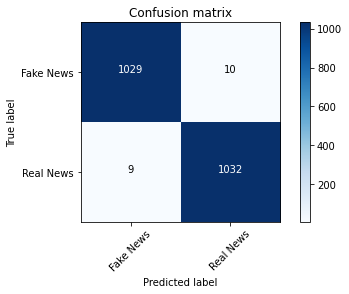

In [59]:
model_report(tree, X_test, Y_test)

In [60]:
parameters_PassiveAggressive = {'C': (0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.),
                                'fit_intercept': (True, False),
                                'n_iter_no_change': (1, 2, 3, 5, 8, 13, 21, 50),
                                'shuffle': (True, False),
                                'loss': ('hinge', 'squared_hinge'),
                                'warm_start': (True, False)}


In [61]:
pa_params = GridSearchCV(PassiveAggressiveClassifier(), parameters_PassiveAggressive, cv = 10)
pa_params.fit(X_train, Y_train)

GridSearchCV(cv=10, estimator=PassiveAggressiveClassifier(),
             param_grid={'C': (0.6, 0.8, 1, 1.2, 1.4, 1.6, 1.8, 2.0),
                         'fit_intercept': (True, False),
                         'loss': ('hinge', 'squared_hinge'),
                         'n_iter_no_change': (1, 2, 3, 5, 8, 13, 21, 50),
                         'shuffle': (True, False),
                         'warm_start': (True, False)})

In [62]:
pa_params.best_params_

{'C': 0.8,
 'fit_intercept': True,
 'loss': 'squared_hinge',
 'n_iter_no_change': 5,
 'shuffle': True,
 'warm_start': False}

In [63]:
clf = BaggingClassifier(
    base_estimator=PassiveAggressiveClassifier(n_iter_no_change=50, early_stopping=True, random_state = 42),
    n_estimators = 1,
    random_state = 42,
).fit(X_train, Y_train)

50.1577287066246
              precision    recall  f1-score   support

           0       0.67      0.01      0.01       317
           1       0.50      1.00      0.67       317

    accuracy                           0.50       634
   macro avg       0.58      0.50      0.34       634
weighted avg       0.58      0.50      0.34       634

Confusion matrix, without normalization


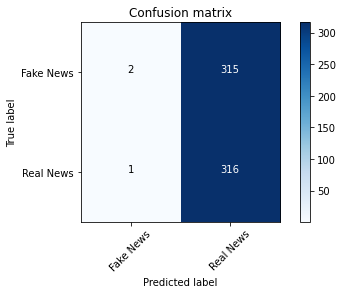

In [64]:
model_report(clf, X_additional_test[:, :17128], y_additional_test)

In [65]:
perc = Perceptron()

perc.fit(X_train, Y_train)

Perceptron()

98.65384615384616
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1039
           1       0.98      0.99      0.99      1041

    accuracy                           0.99      2080
   macro avg       0.99      0.99      0.99      2080
weighted avg       0.99      0.99      0.99      2080

Confusion matrix, without normalization


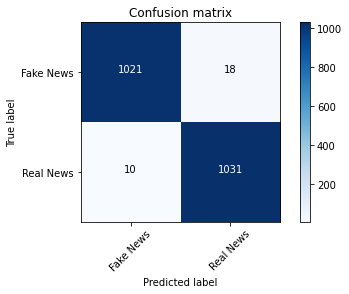

In [66]:
model_report(perc, X_test, Y_test)

In [67]:
sgd = SGDClassifier(loss = 'squared_hinge', random_state = 42, warm_start = True, alpha = .0000000000000001)

sgd.partial_fit(X_train, Y_train, classes = [0, 1])

sgd.partial_fit(X_additional_train[:, :17128], y_additional_train)

SGDClassifier(alpha=1e-16, loss='squared_hinge', random_state=42,
              warm_start=True)

88.84615384615384
              precision    recall  f1-score   support

           0       0.82      0.99      0.90      1039
           1       0.99      0.78      0.88      1041

    accuracy                           0.89      2080
   macro avg       0.91      0.89      0.89      2080
weighted avg       0.91      0.89      0.89      2080

Confusion matrix, without normalization


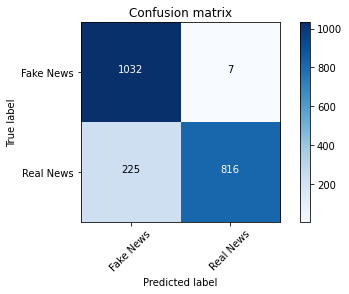

In [68]:
model_report(sgd, X_test, Y_test)

62.30283911671924
              precision    recall  f1-score   support

           0       0.64      0.55      0.59       317
           1       0.61      0.69      0.65       317

    accuracy                           0.62       634
   macro avg       0.63      0.62      0.62       634
weighted avg       0.63      0.62      0.62       634

Confusion matrix, without normalization


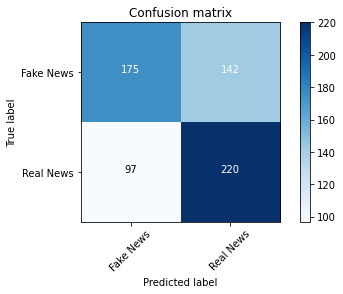

In [69]:
model_report(sgd, X_additional_test[:, :17128], y_additional_test)

In [70]:
bag_pa = BaggingClassifier(PassiveAggressiveClassifier(random_state = 42), random_state = 42)

bag_pa.fit(X_train, Y_train)

BaggingClassifier(base_estimator=PassiveAggressiveClassifier(random_state=42),
                  random_state=42)

In [71]:
cal_pa = CalibratedClassifierCV(bag_pa)

cal_pa.fit(X_train, Y_train)

NameError: name 'CalibratedClassifierCV' is not defined

In [ ]:
model_report(cal_pa, X_test, Y_test)

In [ ]:
model_report(cal_pa, X_additional_test[:, :17128], y_additional_test)

In [ ]:
clf1 = BaggingClassifier(PassiveAggressiveClassifier(random_state = 42)).fit(X_train, Y_train)
clf2 = BaggingClassifier(LogisticRegression(random_state = 42)).fit(X_train, Y_train)
clf3 = BaggingClassifier(DecisionTreeClassifier(random_state = 42)).fit(X_train, Y_train)
clf4 = BaggingClassifier(RidgeClassifier(random_state = 42)).fit(X_train, Y_train)
clf5 = BaggingClassifier(SGDClassifier(random_state = 42)).fit(X_train, Y_train)
clf6 = BaggingClassifier(Perceptron(random_state = 42)).fit(X_train, Y_train)
clf7 = BaggingClassifier(RandomForestClassifier(n_estimators = 50, random_state = 42)).fit(X_train, Y_train)

final_clf = BaggingClassifier(AdaBoostClassifier(random_state = 42)).fit(X_train, Y_train)

In [ ]:
stack = StackingClassifier(
    estimators = [
        ('pa', clf1),
        ('lgr', clf2),
        ('tree', clf3),
        ('ridge', clf4),
        ('sgd', clf5),
        ('perceptron', clf6),
        ('f', clf7),
    ],
    final_estimator = final_clf,
    stack_method = 'predict'
)


stack.fit(X_train, Y_train)

In [ ]:
model_report(stack, X_test, Y_test)

In [ ]:
model_report(stack, X_additional_test[:, :17128], y_additional_test)

In [ ]:
vote = VotingClassifier(
    estimators = [
        ('lgr', clf2),
        ('tree', clf3),
        ('sgd', clf5),
        ('perceptron', clf6),
        ('f', clf7),
    ],
    voting = 'soft'
)

vote.fit(X_train, Y_train)

In [ ]:
model_report(vote, X_test, Y_test)

In [ ]:
model_report(vote, X_additional_test[:, :17128], y_additional_test)

In [ ]:
ada = BaggingClassifier(
    AdaBoostClassifier(
        LogisticRegression(),
        random_state = 42,
        n_estimators = 100,
        learning_rate = 2
    ),
    random_state = 42
).fit(X_train, Y_train)

In [ ]:
ada.score(X_test, Y_test)

In [ ]:
model_report(ada, X_additional_test[:, :17128], y_additional_test)